# How-to: Read-in, process and display UK Met Office radar data.

Daniel Sanchez-Rivas<sup>1</sup> and Miguel A. Rico-Ramirez<sup>1</sup>

<sup>1</sup>Department of Civil Engineering, University of Bristol, Bristol, BS8 1TR, United Kingdom

## This notebook describes the process of retrieving, quality-check and processing raw C-band radar data collected by the operational UK Met Office radar network.

UK Met Office C-band rain radar dual-polarisation products are available at http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499 (Met Office, 2003)

### Import relevant packages

wradlib is required to compute KDP, uncomment if needed.

In [1]:
import numpy as np
import towerpy as tp
import cartopy.crs as ccrs

# %matplotlib notebook


You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:

https://doi.org/10.1016/j.envsoft.105746.2023



### Define working directory and file name

For this example, we'll use data collected at the Chenies radar site; *augzdr* stands for polarimetric data, *lp* for long-pulse and *el0* refers to collected at 0.5&deg; elevation angle.

In [2]:
rsite = 'chenies'
fdir = f'../../../datasets/{rsite}/y2020/lpel0/'
fname = (f'metoffice-c-band-rain-radar_{rsite}_202010030729_raw-dual-polar-'
         + 'augzdr-lp-el0.dat')

### Use of Towerpy to read in the raw radar variables.

The **Rad_scan class** initialises a radar object. 

Within the **ukmo module**, the *ppi_ukmoraw* function provides an interface to read the current binary format used by the MO to store the radar data.

Note that the argument *exclude_vars* was used to discard the 'W [m/s]', 'SQI [-]' and 'CI [dB]'] variables, as they  will not be used at this stage.

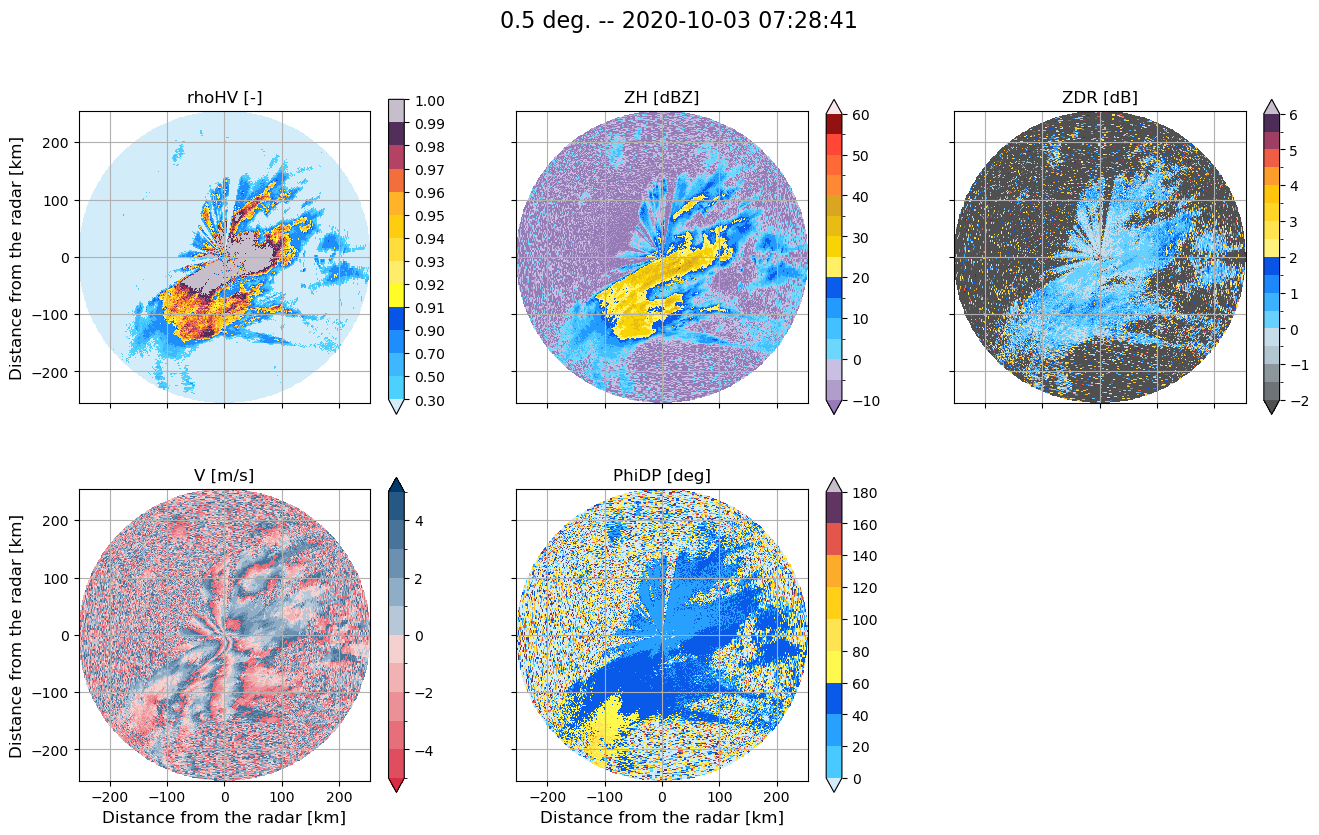

In [3]:
rdata = tp.io.ukmo.Rad_scan(fdir+fname, rsite)
rdata.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])
rdata.ppi_ukmogeoref()

# Plot all the radar variables
tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params, rdata.vars)

### Computation of the Signal-to-Noise-Ratio

We use the *signalnoiseratio* function to compute the Signal-to-Noise-Ratio (SNR) (in dB) and discard data using a reference noise value equal to 35 dB.
This value had been checked at all the UK Met office radar sites (valid only for long-pulse scans) and proved effective in removing noise within the scans.

The *data2correct* argument copies the original data and generates a new dictionary containing radar variables but SNR filtered.

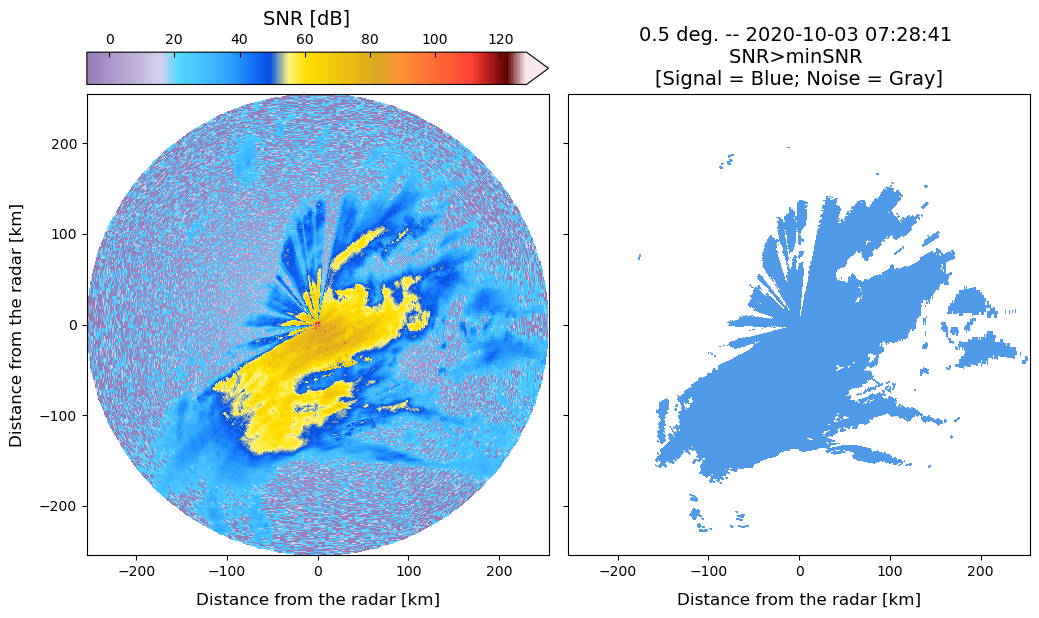

In [4]:
rsnr = tp.eclass.snr.SNR_Classif(rdata)
min_snr = 35
rsnr.signalnoiseratio(rdata.georef, rdata.params, rdata.vars, min_snr=min_snr,
                      data2correct=rdata.vars, plot_method=True)

### PhiDP offset correction

There is a function implemented in Towerpy for estimating $\Phi_{DP}(0)$. Note that the output is similar to that obtained from VPs (40 deg).

In [5]:
ropdp = tp.calib.calib_phidp.PhiDP_Calibration(rdata)
ropdp.offsetdetection_ppi(rsnr.vars)
print(f'Phi_DP(0) = {ropdp.phidp_offset:.2f}')

ropdp.offset_correction(rsnr.vars['PhiDP [deg]'],
                        phidp_offset=ropdp.phidp_offset,
                        data2correct=rsnr.vars)

Phi_DP(0) = 36.83


### Classification of non-meteorological echoes

Towerpy provides membership functions (MFS) to detect clutter echoes. These MFS were calibrated using C-band radar data. We plot the MFS using the *plot_mfs* function.

Note that the textures of polarimetric variables are a great clutter/meteorological echo discriminators!

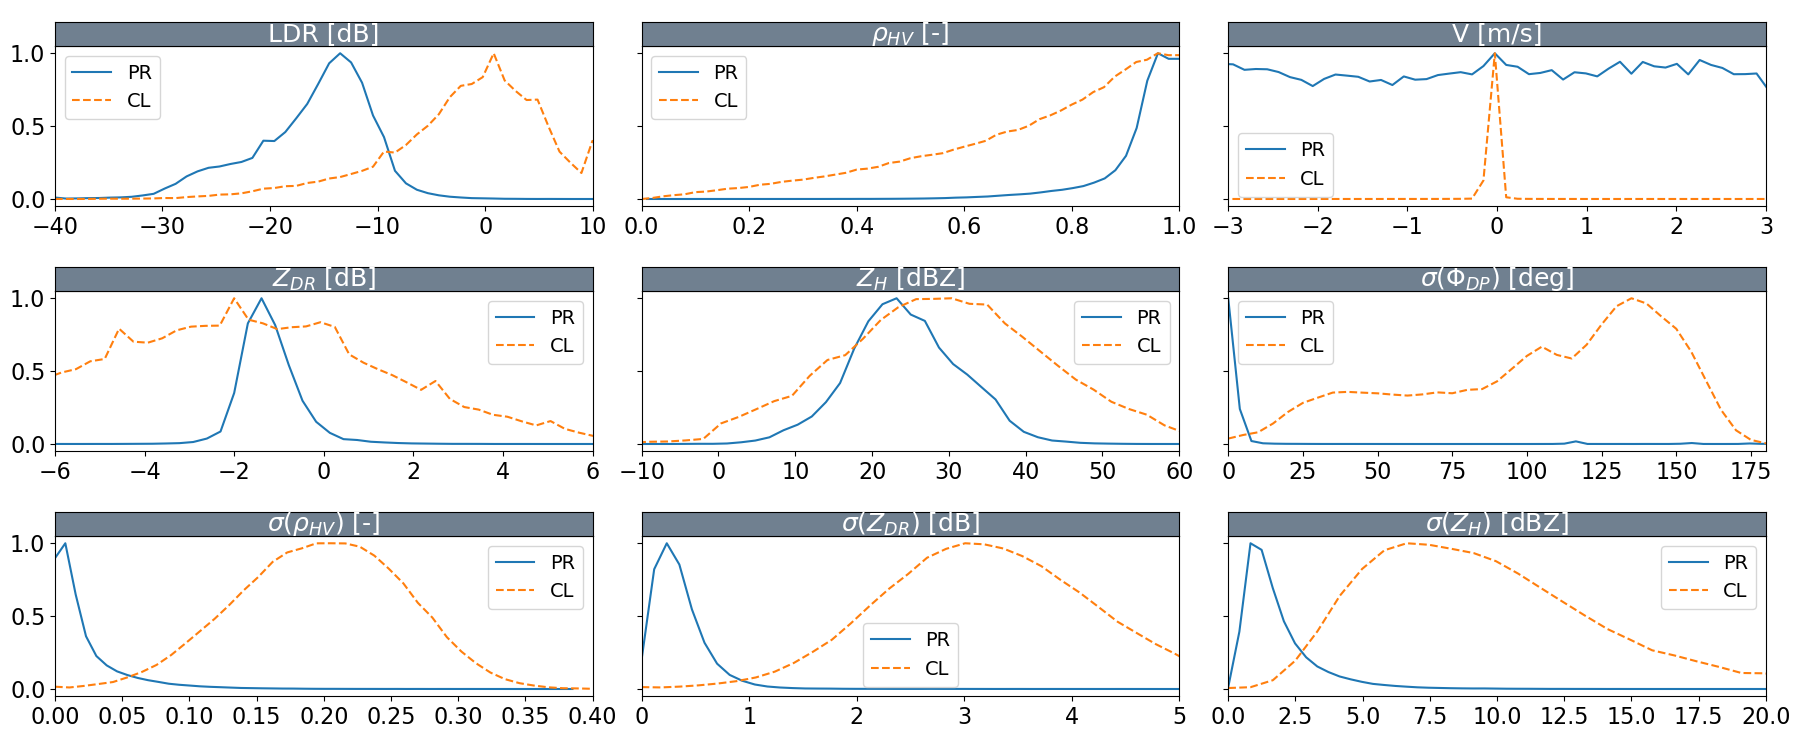

In [6]:
tp.datavis.rad_display.plot_mfs(f'../../../towerpy/eclass/mfs_cband/')

We use the *clutter_id* function to identify clutter echoes. This function is based on the methodology proposed by Rico-Ramirez, M. A., & Cluckie, I. D. (2008).

This function requires descriptors of the azimuth, gates and other georeferenced data (*rdata.georef*); radar technical details (*rdata.params*); radar variables (*rdata.vars*), and other arguments that can be customised by the user.

As we're working with Chenies radar data taken at 0.5 elevation angle, we load the array that contains the corresponding clutter map.

As above, The *data2correct* argument copies given data and generates a new dictionary containing radar variables but with the clutter echoes removed.

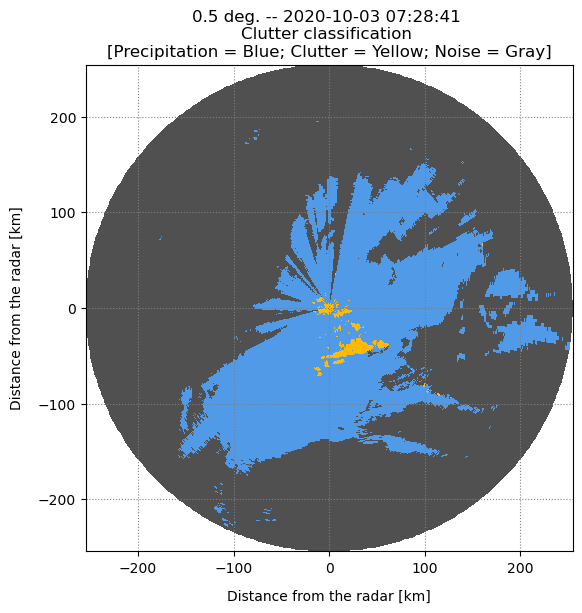

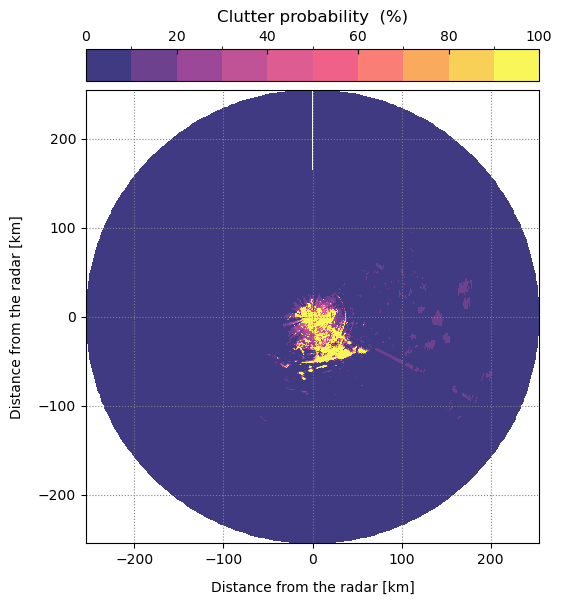

In [7]:
clmap = f'../../../towerpy/eclass/ukmo_cmaps/{rsite}/chenies_cluttermap_el0.dat'

rnme = tp.eclass.nme.NME_ID(rsnr)
rnme.clutter_id(rdata.georef, rdata.params, ropdp.vars, binary_class=223,
                min_snr=rsnr.min_snr, clmap=np.loadtxt(clmap),
                data2correct=ropdp.vars, plot_method=True)

### Definition of the melting layer boundaries

We create a MeltingLayer object to set the melting level height and the melting layer thickness.
These heights are important to delimit the rain region within the PPI scan. For this step, we estimated the melting layer boundaries from [QVPs](https://towerpy.readthedocs.io/en/latest/notebooks/radchain_ukmo9.html), but **assuming an isotropic melting layer.**

We can use the *ml_ppidelimitation* function to create a PPI depicting the limits of the melting layer.

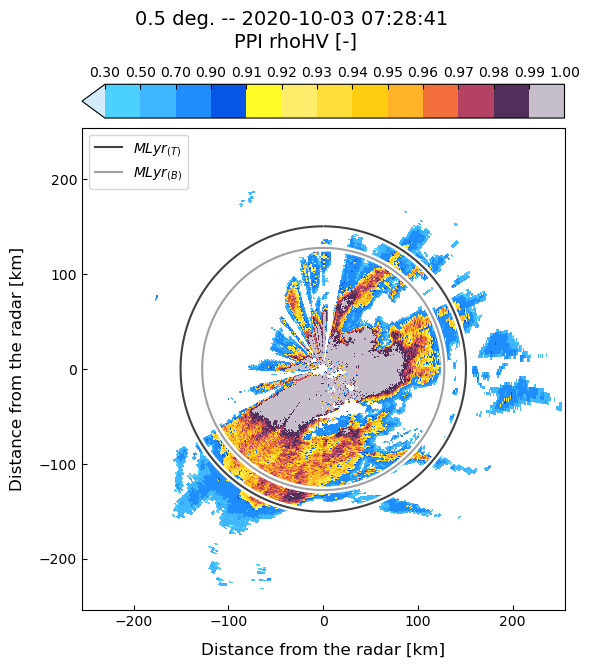

In [8]:
rmlyr = tp.ml.mlyr.MeltingLayer(rdata)
rmlyr.ml_top = 2.64
rmlyr.ml_thickness = 0.57
rmlyr.ml_bottom = 2.08

rmlyr.ml_ppidelimitation(rdata.georef, rdata.params, rsnr.vars)

# Plot rhoHV and the ML
tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rnme.vars, var2plot='rhoHV [-]', mlyr=rmlyr)

### Calibration of $Z_{DR}$

We create a ZDR_Calibration object to define and correct the $Z_{DR}$.
For this example, the $Z_{DR}$ offset is set as -0.27. This value was derived from [QVPs](https://towerpy.readthedocs.io/en/latest/notebooks/radchain_ukmo9.html) and corroborated with [birdbath scans](https://towerpy.readthedocs.io/en/latest/notebooks/radchain_ukmo90.html).

In [9]:
rozdr = tp.calib.calib_zdr.ZDR_Calibration(rdata)
rozdr.offset_correction(rnme.vars['ZDR [dB]'],
                        zdr_offset=-0.27,
                        data2correct=rnme.vars)

### Attenuation correction

The next step is to correct the attenuation of the radar signal. We use the algorithms proposed by Bringi, V. N. et al (2001) and Rico-Ramirez, M. A. (2012).

The *AttenuationCorrection* object contains two functions, *zh_correction* and *zdr_correction* that correct the attenuation on $Z_H$ and $Z_{DR}$, respectively.

**Note that the attenuation is computed up to a user-defined height that correspond to the rain region within the PPI scan.**

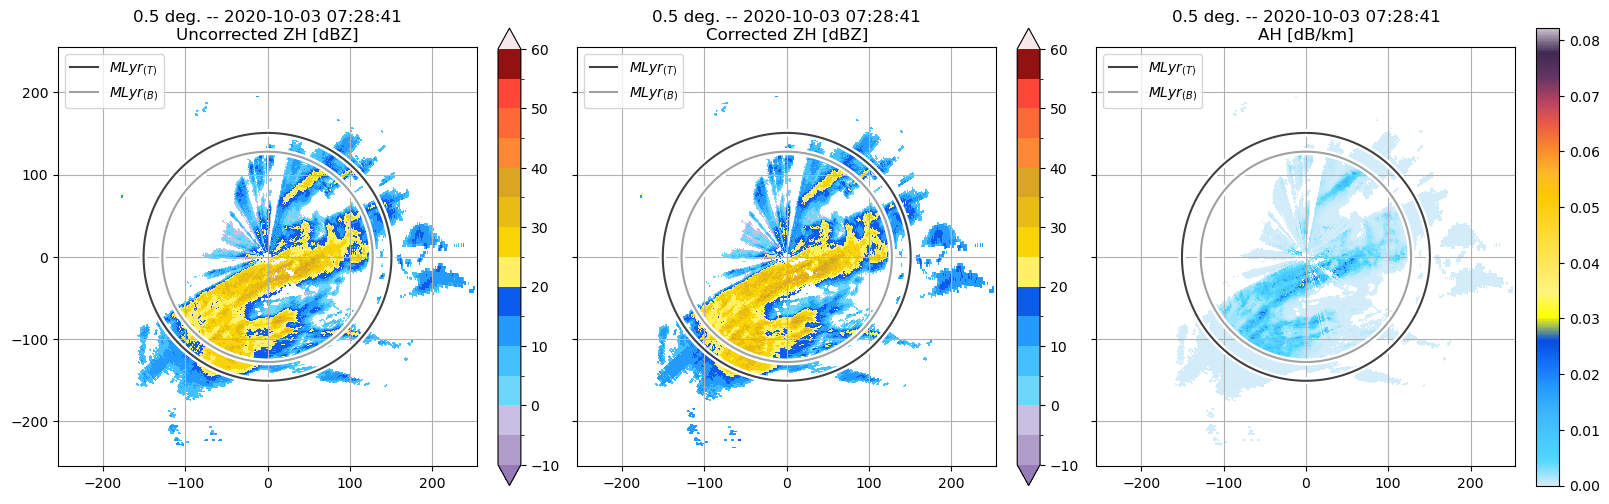

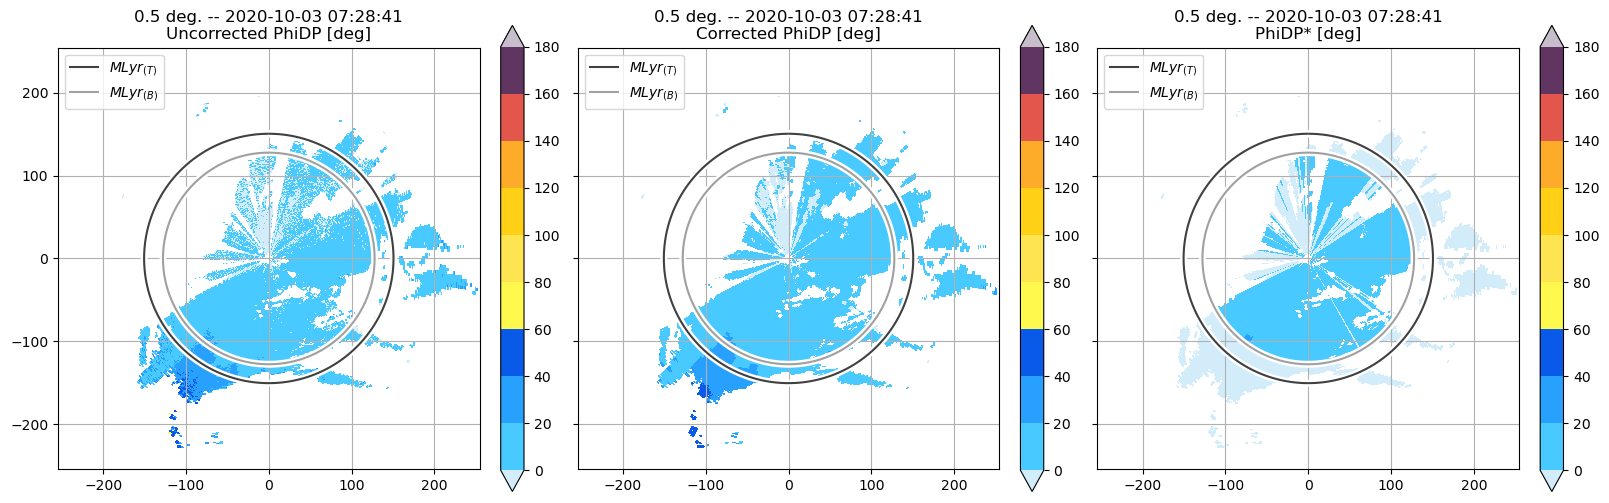

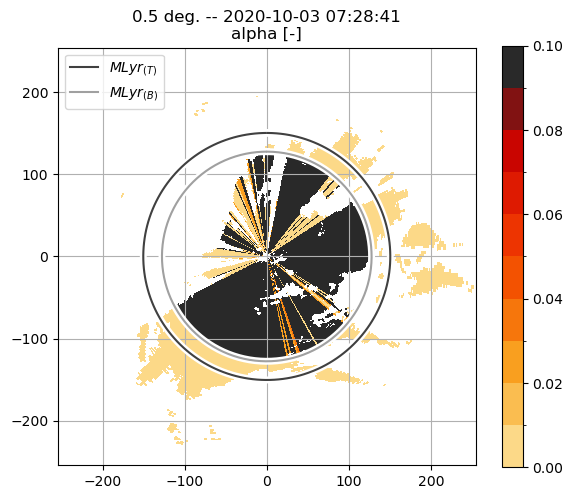

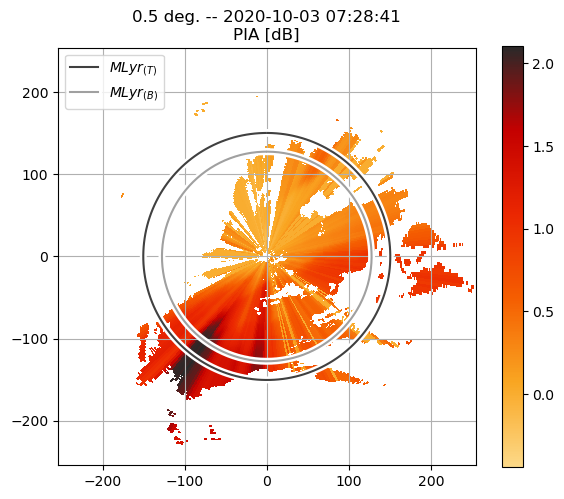

In [10]:
rattc = tp.attc.attc_zhzdr.AttenuationCorrection(rdata)
rattc.zh_correction(rdata.georef, rdata.params, rozdr.vars,
                    rnme.nme_classif['classif'], attc_method='ABRI',
                    mlyr=rmlyr, pdp_pxavr_azm=3, pdp_dmin=1,
                    pdp_pxavr_rng=round(4000/rdata.params['gateres [m]']),
                    plot_method=True)

### Partial Beam Blockage correction

The partial beam blockage is corrected using the method proposed by Diederich, M. et al (2015).

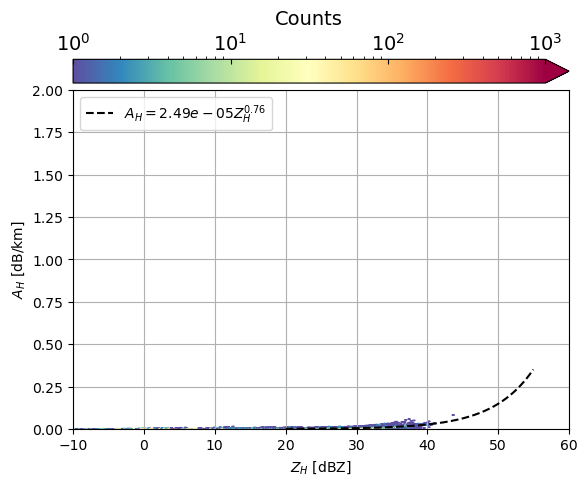

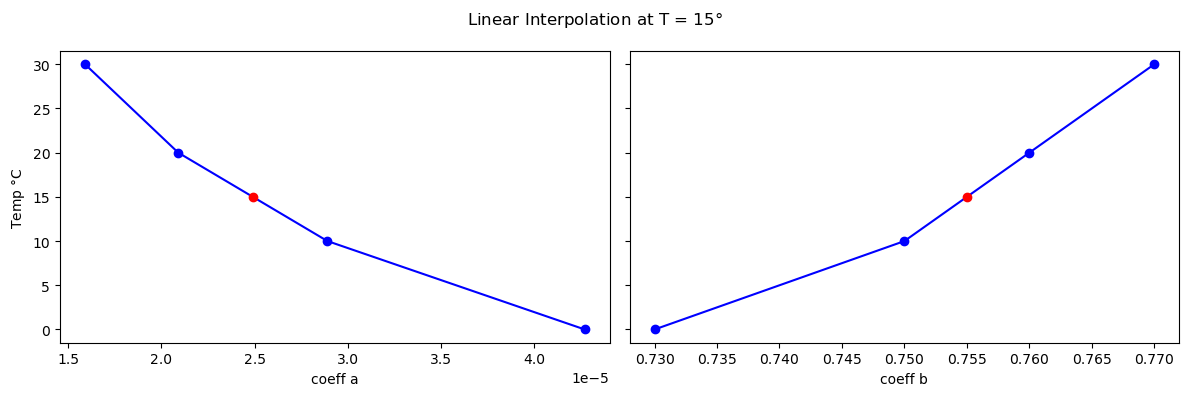

In [11]:
temp = 15
rzhah = tp.attc.r_att_refl.Attn_Refl_Relation(rdata)
rzhah.ah_zh(rattc.vars, rband='C', zh_upper_lim=55, temp=temp, copy_ofr=True,
            data2correct=rattc.vars, plot_method=True)
rattc.vars['ZH* [dBZ]'] = rzhah.vars['ZH [dBZ]']


The plot_ppidiff function is useful to visualise the results of the PBB correction:

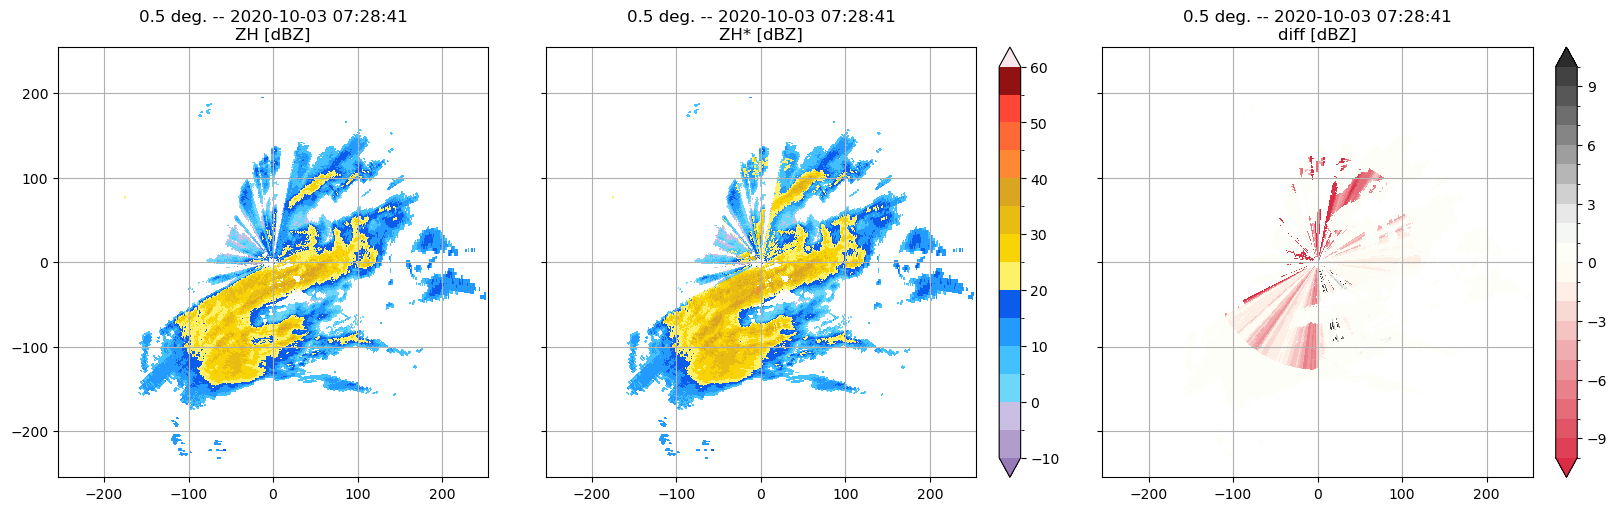

In [12]:
tp.datavis.rad_display.plot_ppidiff(rdata.georef, rdata.params, rattc.vars,
                                        rattc.vars, var2plot1='ZH [dBZ]',
                                        var2plot2='ZH* [dBZ]')

### ZDR attenuation correction


The *zdr_correction* function requires the outputs of the $Z_H$ attenuation correction (i.e., $\alpha, A_h$) to compute the specific differential attenuation, 


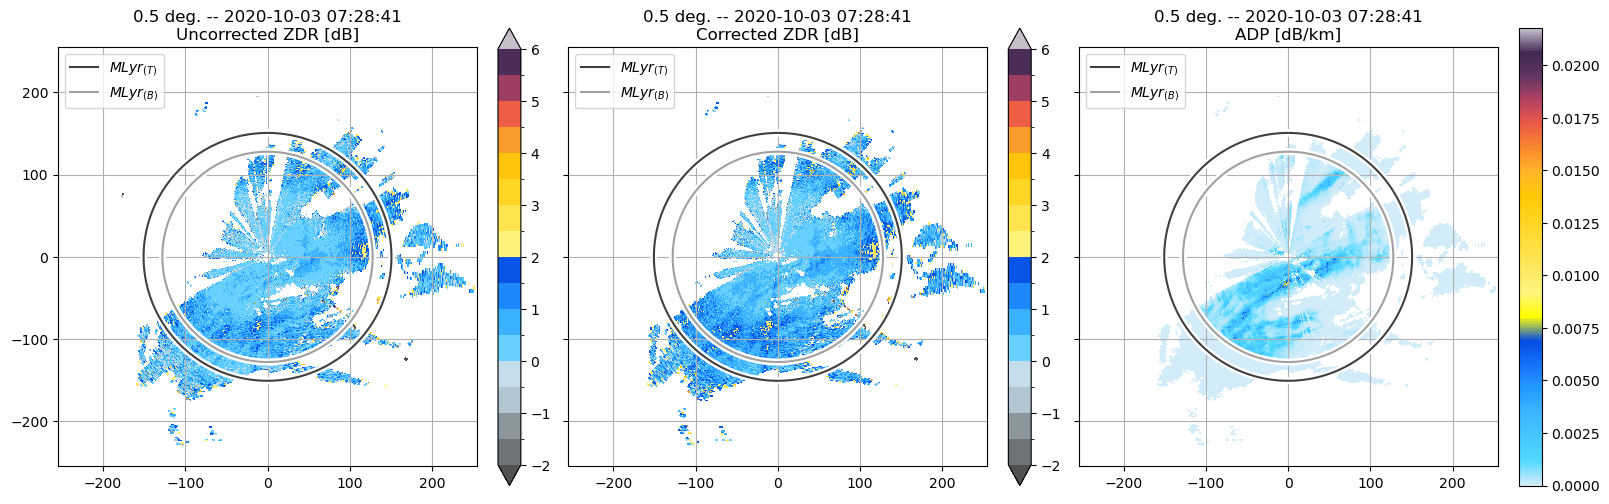

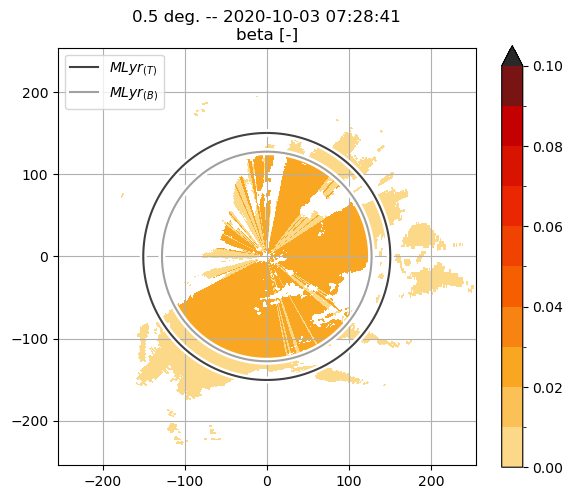

In [13]:
rattc.zdr_correction(rdata.georef, rdata.params, rozdr.vars, rattc.vars,
                     rnme.nme_classif['classif'], mlyr=rmlyr, rhv_thld=0.985,
                     minbins=9, mov_avrgf_len=5, p2avrf=3,
                     plot_method=True)

### $K_{DP}$ computation

$K_{DP}$ is an output of the rattc.zh_correction function!

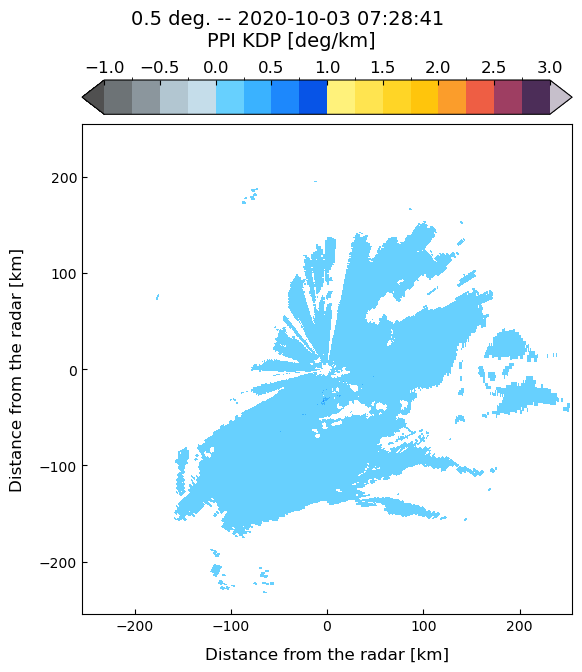

In [14]:
tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rattc.vars,
                                 var2plot='KDP [deg/km]',
                                 vars_bounds={'KDP [deg/km]': (-1, 3, 17)})

### Quantitative Precipitation estimation

We use the **RadarQPE** class to initialise a radar QPE object. 

This class contains several rain estimators, and the coefficients used in each algorithm can be modified by the user depending on the radar frequency or the rainfall regime.

In [15]:
rqpe = tp.qpe.qpe_algs.RadarQPE(rdata)

rqpe.z_to_r(rattc.vars['ZH* [dBZ]'], a=200, b=1.6, mlyr=rmlyr,
            beam_height=rdata.georef['beam_height [km]'])
rqpe.ah_to_r(rattc.vars['AH [dB/km]'], mlyr=rmlyr,
             beam_height=rdata.georef['beam_height [km]'])
rqpe.z_zdr_to_r(rattc.vars['ZH [dBZ]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
                beam_height=rdata.georef['beam_height [km]'])
rqpe.kdp_zdr_to_r(rattc.vars['KDP [deg/km]'], rattc.vars['ZDR [dB]'], mlyr=rmlyr,
                  beam_height=rdata.georef['beam_height [km]'])

In [16]:
help(rqpe.ah_to_r)

Help on method ah_to_r in module towerpy.qpe.qpe_algs:

ah_to_r(ah, rband='C', temp=20.0, a=None, b=None, mlyr=None, beam_height=None) method of towerpy.qpe.qpe_algs.RadarQPE instance
    Compute rain rates using the :math:`R(A_{H})` estimator [Eq.1]_.
    
    Parameters
    ----------
    ah : float or array
        Floats that corresponds to the specific attenuation, in dB/km.
    rband: str
        Frequency band according to the wavelength of the radar.
        The string has to be one of 'S', 'C' or 'X'. The default is 'C'.
    temp: float
        Temperature, in :math:`^{\circ}C`, used to derive the coefficients
        a, b according to [1]_. The default is 20.
    a, b : floats
        Override the default coefficients of the :math:`R(A_{H})`
        relationship. The default are None.
    mlyr : MeltingLayer Class, optional
        Melting layer class containing the top of the melting layer, (i.e.,
        the melting level) and its thickness. Only gates below the melting
   

We use the *plot_ppi* function to display the rain product on a map with a projection corresponding to the location of the radar.

©Natural Earth; license: public domain


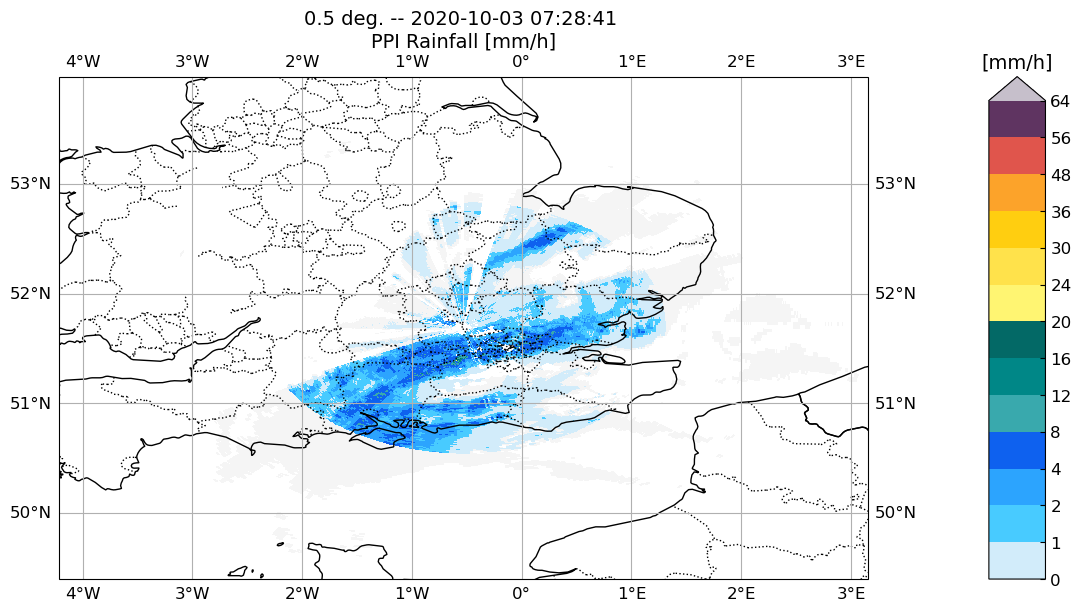

In [17]:
# Plot the radar data in a map
tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params, rqpe.r_z,
                                data_proj=ccrs.OSGB(approx=False),
                                cpy_feats={'status': True}, fig_size = (12, 6))

Finally, we use other functions within the **datavis** module to explore the radar data.

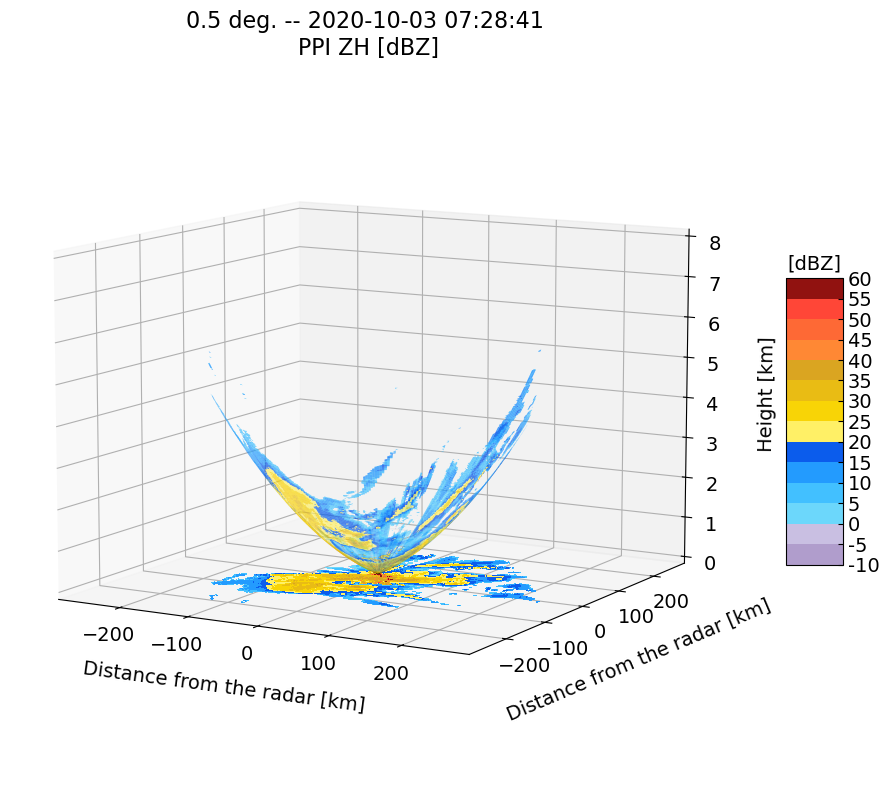

In [18]:
# Plot cone coverage
tp.datavis.rad_display.plot_cone_coverage(rdata.georef, rdata.params,
                                          rsnr.vars)

### The **rad_interactive** module

This module helps explore the PPI scans. For instance, the **user can store the coordinates of the current position of the mouse pointer by pressing a number (0-9)**. This is useful for classifying pixels, e.g. 0 for meteorological echoes, 3 for noise and 5  for non-meteorological ones, in accordance with the *clutter_id* function.


 
 
  Right-click on a pixel within the PPI to select its 
  azimuth or use the n and m keys to browse through the next 
  and previous azimuth.                                      
  Radial profiles of polarimetric variables will be shown at 
  the axes on the right.                                     
  Press a number (0-9) to store the coordinates and value    
  of the current position of the mouse pointer.              
  These coordinate can be retrieved at                       
  ppiexplorer.clickcoords                                    


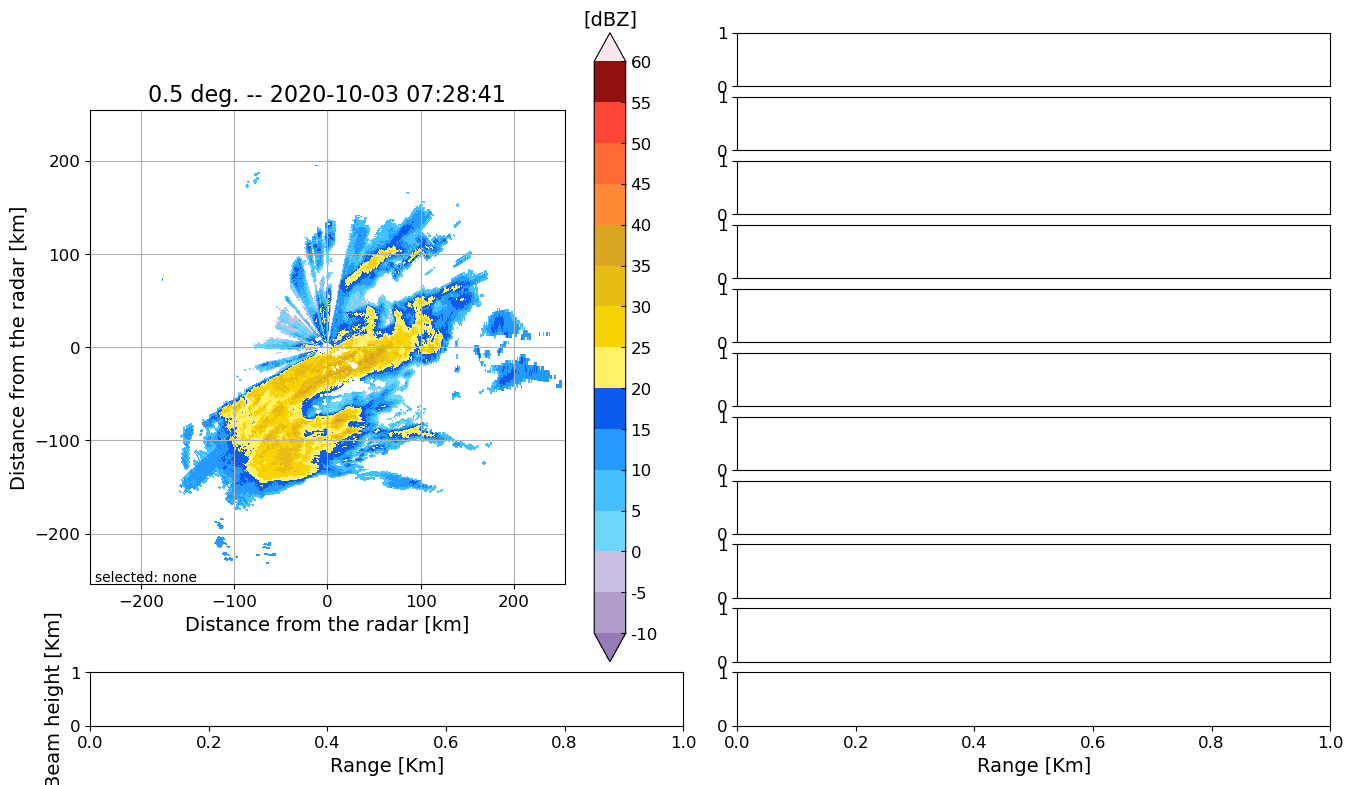

In [19]:
# Plot an interactive PPI explorer
tp.datavis.rad_interactive.ppi_base(rdata.georef, rdata.params, rattc.vars)
ppiexplorer = tp.datavis.rad_interactive.PPI_Int()
# %%
# ppiexplorer.savearray2binfile(file_name=fname, dir2save='/fdir2/')

In [20]:
ppiexplorer.clickcoords

[]

## References

V. N. Bringi, T. D. Keenan and V. Chandrasekar, "Correcting C-band radar reflectivity and differential reflectivity data for rain attenuation: a self-consistent method with constraints," in IEEE Transactions on Geoscience and Remote Sensing, vol. 39, no. 9, pp. 1906-1915, Sept. 2001, https://doi.org/10.1109/36.951081

Diederich, M., Ryzhkov, A., Simmer, C., Zhang, P., & Trömel, S. (2015). Use of Specific Attenuation for Rainfall Measurement at X-Band Radar Wavelengths. Part I: Radar Calibration and Partial Beam Blockage Estimation. Journal of Hydrometeorology, 16(2), 487-502. https://doi.org/10.1175/JHM-D-14-0066.1

Met Office (2003): Met Office Rain Radar Data from the NIMROD System. NCAS British Atmospheric Data Centre, 2022. http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499

Rico-Ramirez, M. A., & Cluckie, I. D. (2008). Classification of ground clutter and anomalous propagation using dual-polarization weather radar. IEEE Transactions on Geoscience and Remote Sensing, 46(7), 1892-1904. https://doi.org/10.1109/TGRS.2008.916979

Rico-Ramirez, M. A. (2012) "Adaptive Attenuation Correction Techniques for C-Band Polarimetric Weather Radars," in IEEE Transactions on Geoscience and Remote Sensing, vol. 50, no. 12, pp. 5061-5071, Dec. 2012. https://doi.org/10.1109/TGRS.2012.2195228